In [1]:
!pip install pennylane

In [2]:
!pip install tensorflow

In [3]:
from google.colab import files
uploaded = files.upload()

Saving QNNs.png to QNNs.png


## <center>Tutorial on Quanvolutional Neural Networks</center>

**Goal:** Work through the example (https://pennylane.ai/qml/demos/tutorial_quanvolution/), Implement and present your steps in a notebook and comment on the important steps.

Classically, Convolutional Neural Networks (CNNs) are a type of deep learning model specifically designed for processing and analyzing visual data such as images and videos. Within its network architecture, CNNs comprises a series of convolutional layers which extracts features using filters (kernel). The output of each convolutional layer is then downsampled using pooling layers to reduce dimensionality and capture the most salient information. Finally, the resulting feature maps are Flattened and fed into one more Fully connected layers, which performs the classification or regression task.

A Quanvolutional Neural Network (QNN) is a type of neural network architecture that extend the capabilities of CNNs by leveraging certain potentially powerful aspects of quantum computation.

QNNs add a new type of transformational layer to the standard CNN architecture: the quantum convolutional (or quanvolutional) layer.Comprising a set of N quantum filters, quanvolutional layers function similarly to their conventional convolutional layer equivalents by creating feature maps through locally modifying input data. Quanvolutional filters vary primarily in that they use random quantum circuits to alter spatially-local subsections of input data in order to extract features from the data.


Following the procedure described by Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook. “Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits.” arXiv:1904.04767, 2019, and based on https://pennylane.ai/qml/demos/tutorial_quanvolution/ we will implement (in PennyLane) the model as shown in the following figure:


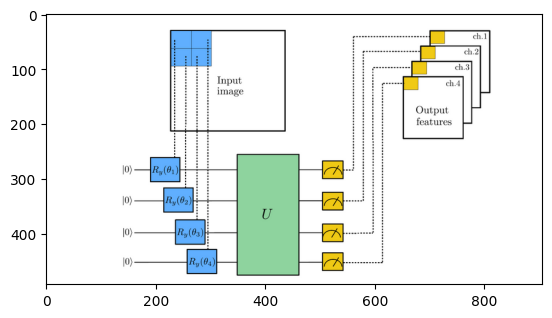

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
image_path='QNNs.png'
img=Image.open(image_path)
plt.imshow(img)

**First, we import the necessary libraries and modules we will need**


In [17]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers #provides templates for random quantum circuits.
import tensorflow as tf
from tensorflow import keras                 #for building and training neural networks.
import matplotlib.pyplot as plt

In [18]:
#Setting of the main hyper-parameters of the model (can be changed)
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of layers for the random circuit
n_train = 50#1000 #50  # Size of the train dataset
n_test = 30#600  #30 # Size of the test dataset
wires=4

Prepare the Data

Use a dataset to train the model. In this example, we use the MNIST dataset downloaded from (https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz). To speedup the evaluation of this demo we use only a small number of training and test images.


In [19]:
#Load the MNIST Dataset
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

Next, following the scheme described in the paper and represented in the figure above, we define the Quantum Circuit to be used in the Quanvolutional layer


In [20]:

# Define the quantum device
dev = qml.device("default.qubit", wires=wires)

# Generate random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, wires))

# Define the quantum node
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(wires):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit using StronglyEntanglingLayers
    RandomLayers(rand_params, wires=list(range(wires)))

    # Measurement in the computational basis producing 4 classical output values (expectation values)
    return [qml.expval(qml.PauliZ(j)) for j in range(wires)]

In [21]:
# train_images

Next, We define a function quanv(image) that performs convolution on image data to extract features using a quantum circuit. It divides the image into 2x2 regions (squares of 2x2 pixels) and processes each region using a quantum circuit. The results are then stored in the output array.

This process halves the resolution of the input image (corresponding to a convolution with a 2×2 kernel and a stride equal to 2 in CNNs).

4 channels or expectation values or measurements produced by the quantum circuit for each 2x2 block.

 function takes the top-left coordinates of the region as inputs and returns the results of the quantum circuit.

In [22]:
img_height=28
img_width=28
block_size=2
num_channels=wires
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    #Specify the dimensions of the input image
    out_height = img_height // block_size
    out_width = img_width // block_size

    #store the results of the quantum circuit for each 2x2 block of the input image.
    out = np.zeros((out_height, out_width, num_channels))

    def process_region(i, j):
        """Process a 2x2 region of the image with the quantum circuit."""
        return circuit([
            image[i, j, 0],
            image[i, j + 1, 0],
            image[i + 1, j, 0],
            image[i + 1, j + 1, 0]
        ])
# Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, img_height, block_size):
        for k in range(0, img_width, block_size):
            q_results = process_region(j, k)

            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(num_channels):
                out[j // block_size, k// block_size, c] = q_results[c]
    return out
#             out[j // block_size, k // block_size, :] = q_results

#     return out



Quantum pre-processing of the dataset before feding into the models

Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a “pre-processing” layer to all the images of our dataset.

In [23]:
print("Quantum preprocessing of train images:")
q_train_images = [quanv(img) for img in train_images]
q_train_images = np.asarray(q_train_images)

print("Quantum preprocessing of test images:")
q_test_images = [quanv(img) for img in test_images]
q_test_images = np.asarray(q_test_images)


Quantum preprocessing of train images:
Quantum preprocessing of test images:


Let us visualize the effect of the quantum convolution layer on a batch of samples:

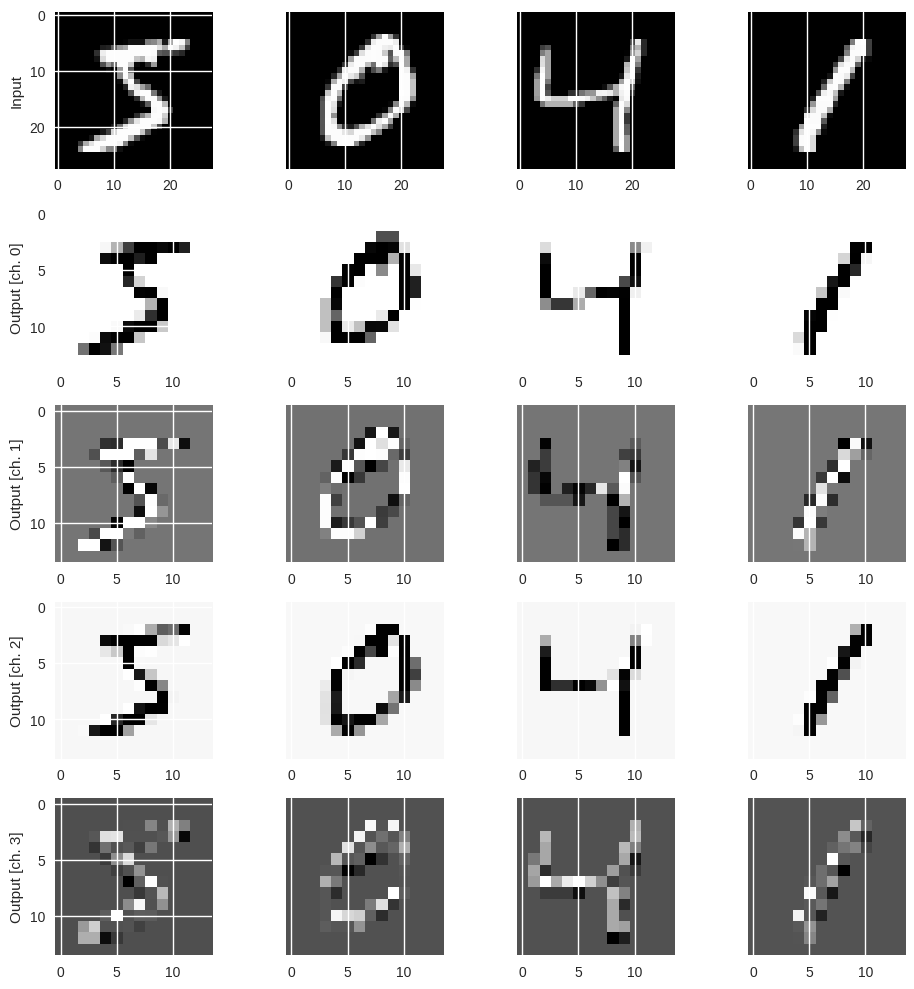

In [24]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))

for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel(f"Output [ch. {c}]")
        if k != 0:
            axes[c + 1, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()


After the application of the quantum convolution layer we feed the resulting features into a classical neural network that will be trained to classify the 10 different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output nodes with a final softmax activation function.

The model is compiled with a stochastic-gradient-descent optimizer, and a cross-entropy loss function


Two dense layers are added to the model with 64 and 10 units respectively. The activation function used for the first dense layer is ReLU, and for the second dense layer is softmax.


ReLU is a popular activation function in deep learning due to its ability to introduce non-linearity and handle the vanishing gradient problem.ReLU applies the function max(x, 0) element-wise, where x is the input tensor.

Softmax is commonly used in multi-class classification problems as it produces a probability distribution over the classes.Softmax applies the function exp(x) / sum(exp(x)) element-wise, where x is the input tensor.

Using 64 units provides a sufficient number of parameters to capture complex patterns in the data without being overly complex. This helps in reducing the risk of overfitting, where the model learns noise in the training data, and underfitting, where the model fails to learn the underlying trend

In [25]:
# Define the complete model
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Display the model architecture
# model.summary()


Training

We first initialize an instance of the model, then we train and validate it with the dataset that has been already pre-processed by a quantum convolution.


Train the model using the training data


In [26]:
# Train the model
#model.fit(q_train, y_train, epochs=5, batch_size=32, validation_data=(q_test, y_test),verbose=2)


q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 94ms/step - accuracy: 0.1200 - loss: 2.5107 - val_accuracy: 0.3000 - val_loss: 2.1379
Epoch 2/30
13/13 - 0s - 6ms/step - accuracy: 0.5400 - loss: 1.7484 - val_accuracy: 0.4333 - val_loss: 1.7663
Epoch 3/30
13/13 - 0s - 11ms/step - accuracy: 0.6400 - loss: 1.4578 - val_accuracy: 0.5333 - val_loss: 1.6423
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.8000 - loss: 1.1671 - val_accuracy: 0.6333 - val_loss: 1.4558
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.8800 - loss: 0.8926 - val_accuracy: 0.6000 - val_loss: 1.4524
Epoch 6/30
13/13 - 0s - 12ms/step - accuracy: 0.9400 - loss: 0.6682 - val_accuracy: 0.6667 - val_loss: 1.2805
Epoch 7/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.5097 - val_accuracy: 0.6333 - val_loss: 1.2521
Epoch 8/30
13/13 - 0s - 10ms/step - accuracy: 0.9800 - loss: 0.3904 - val_accuracy: 0.7000 - val_loss: 1.1617
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.2988 - val_accuracy: 0.6667 - val_loss: 1.1629
Epoch 10/30

In order to compare the results achievable with and without the quantum convolution layer, we initialize also a “classical” instance of the model that will be directly trained and validated with the raw MNIST images (i.e., without quantum pre-processing).

In [27]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 92ms/step - accuracy: 0.1600 - loss: 2.3014 - val_accuracy: 0.2333 - val_loss: 2.1474
Epoch 2/30
13/13 - 0s - 9ms/step - accuracy: 0.6600 - loss: 1.7341 - val_accuracy: 0.4000 - val_loss: 1.9971
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.8400 - loss: 1.3180 - val_accuracy: 0.4333 - val_loss: 1.8117
Epoch 4/30
13/13 - 0s - 10ms/step - accuracy: 0.8600 - loss: 0.9849 - val_accuracy: 0.5333 - val_loss: 1.6211
Epoch 5/30
13/13 - 0s - 12ms/step - accuracy: 0.9600 - loss: 0.7063 - val_accuracy: 0.5000 - val_loss: 1.4822
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.9800 - loss: 0.5202 - val_accuracy: 0.5667 - val_loss: 1.3844
Epoch 7/30
13/13 - 0s - 9ms/step - accuracy: 0.9800 - loss: 0.3628 - val_accuracy: 0.6333 - val_loss: 1.2619
Epoch 8/30
13/13 - 0s - 9ms/step - accuracy: 1.0000 - loss: 0.2684 - val_accuracy: 0.6667 - val_loss: 1.2025
Epoch 9/30
13/13 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.2001 - val_accuracy: 0.6667 - val_loss: 1.1779
Epoch 10/30
1

Results

We can finally plot the test accuracy and the test loss with respect to the number of training epochs.


<ipython-input-29-a5ee27d99ce9>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


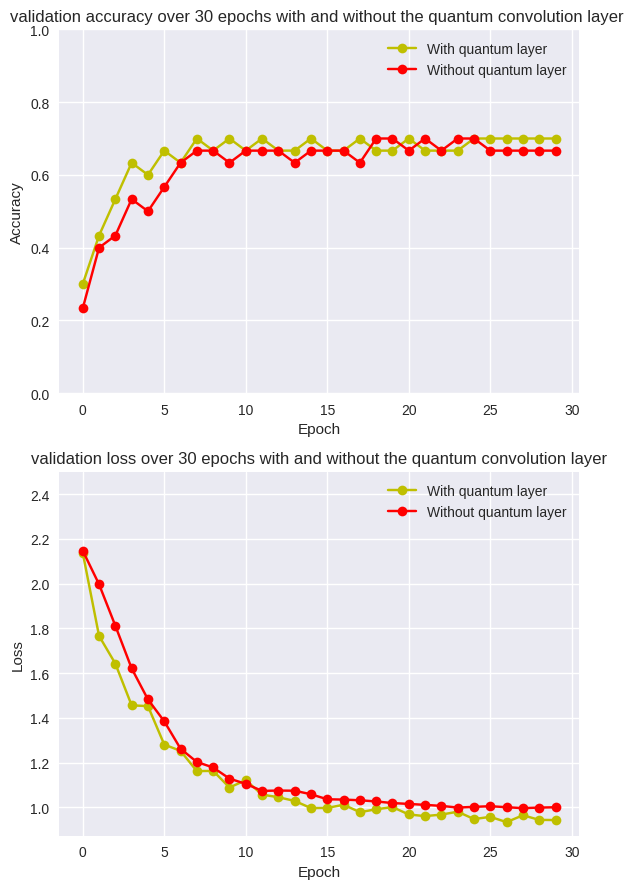

In [29]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-oy", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-or", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.set_title('validation accuracy over 30 epochs with and without the quantum convolution layer ')
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-oy", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-or", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.set_title('validation loss over 30 epochs with and without the quantum convolution layer')
ax2.legend()
plt.tight_layout()
plt.show()

From these figures, we see that the model with the quantum layer starts with higher accuracy compared to the classical model, slighly decreases around 16 epochs but it catches up around epoch 26 and increases compared to the classical model. In terms of performance, we can see that both models stabilize at an accuracy of approximately 0.6 to 0.7, indicating that they have learned to classify the images to a closely similar extent.


Concerning the loss figure, Both models show a rapid decrease in loss within the first 10 epochs. Both models start with high loss values, with the quantum model showing a slightly faster decrease initially but catches up after 4 epochs.
The quantum model converges to a loss around 0.8 and the classical model converges to a  loss value of 1, indicating that the quantum model have minimized the classification error better than the quantum model.

Performance: In terms of accuracy and loss, the quantum model performs better than the classical model by the end of the training process. The initial differences in performance diminish over time as both models learn from the data.
The addition of a quantum layer slighly improve the performance compared to the classical model in this specific experiment.
The model with the quantum layer exhibits slight fluctuations in accuracy, which might be due to the inherent variability in quantum measurements and the random layers used.


In this experiment, the Quanvolutional Neural Network and the classical Convolutional Neural Network perform almost similarly. The quantum layer provide only a very small advantage in terms of accuracy or loss reduction. This suggests that while the quantum approach is promising, its benefits might be more pronounced in different settings or with further optimizations.